# Sequential MNIST results from the paper by Rui Costa et al.:<br/>"Cortical microcircuits as gated-recurrent neural networks" 
## Implementation done in the scope of the nurture.ai NIPS 2017 paper implementation challenge

- nurture.ai challenge: https://nurture.ai/nips-challenge
- Paper: http://papers.nips.cc/paper/6631-cortical-microcircuits-as-gated-recurrent-neural-networks
- Credits:<br/>
 Training logic based on the r2rt LSTM tutorial (https://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html).<br/>
 Model definition based on KnHuq implementation (https://github.com/KnHuq/Dynamic-Tensorflow-Tutorial/blob/master/LSTM/LSTM.py
).

## This notebook compare the results of models with 1 layer (as done in the paper)

### Loading Librairies and Models

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import sys

#import LSTM and subLSTM cell models
sys.path.append('../models/')
from LSTM import *
from subLSTM import *
from parameters import *

sys.path.append('../src/common/')
import helper as hp

### Loading MNIST dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Training Function

In [3]:
def train_network(g, batch_size=50, n_epoch=10, verbose=False, save=False, patience=25, min_delta=0.01):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # parameters for early stopping
        patience_cnt = 0
        max_test_accuracy = 0.0

        #Iterations to do trainning
        for epoch in range(n_epoch):

            X, Y = mnist.train.next_batch(batch_size)
            X = X.reshape(batch_size, 1, g['input_size'])

            sess.run(g['train_step'],feed_dict={g['rnn']._inputs:X, g['y']:Y})
               
            if epoch % 1000 == 0:
                Loss=str(sess.run(g['cross_entropy'],feed_dict={g['rnn']._inputs:X, g['y']:Y}))
                Train_accuracy=str(sess.run(g['accuracy'],feed_dict={g['rnn']._inputs:X, g['y']:Y}))
                X_test = mnist.test.images.reshape(10000,1,g['input_size'])
                Test_accuracy=str(sess.run(g['accuracy'],feed_dict={g['rnn']._inputs:X_test, g['y']:mnist.test.labels}))
                if verbose:
                    print("\rIteration: %s Loss: %s Train Accuracy: %s Test Accuracy: %s"%(epoch,Loss,Train_accuracy,Test_accuracy))
                    
                # early stopping
                if float(Test_accuracy) > max_test_accuracy:
                    max_test_accuracy = float(Test_accuracy)
                    patience_cnt = 0
                else:
                    patience_cnt += 1
                if patience_cnt > patience:
                    print("early stopping at epoch: ", epoch)
                    break
                        
                if isinstance(save, str):
                    g['saver'].save(sess, save)
    
    return max_test_accuracy

### Building Graph Model Function

In [4]:
def build_graph(cell_type=None, load_parameters=False):
    # define initial parameters
    input_size = 784
    output_size = 10
    optimizer = 'Adam'
    momentum = False
    learning_rate = 0.001
    hidden_units = 10
    
    if load_parameters:
        #load parameters from file
        if cell_type == 'LSTM':
            parameters = LSTM_parameters()
        elif cell_type == 'sub_LSTM':
            parameters = SubLSTM_parameters()
        elif cell_type == 'fix_sub_LSTM':
            parameters = Fix_subLSTM_parameters()
        else:
            print("No cell_type selected! Use LSTM cell")
            parameters = LSTM_parameters()
        
        input_size = parameters.mnist['input_size']
        output_size = parameters.mnist['output_size']
        optimizer = parameters.mnist['optimizer']
        momentum = parameters.mnist['momentum']
        learning_rate = parameters.mnist['learning_rate']
        hidden_units = parameters.mnist['hidden_units']

    # reset graph
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()
    
    # Initializing rnn object
    if cell_type == 'LSTM':
        rnn = LSTM_cell(input_size, hidden_units, output_size)
    elif cell_type == 'sub_LSTM':
        rnn = subLSTM_cell(input_size, hidden_units, output_size)
    elif cell_type == 'fix_sub_LSTM':
        print("TODO!")
    else:
        rnn = LSTM_cell(input_size, hidden_units, output_size)
    
    #input label placeholder
    y = tf.placeholder(tf.float32, [None, output_size])
    
    # Getting all outputs from rnn
    outputs = rnn.get_outputs()

    # Getting final output through indexing after reversing
    last_output = outputs[-1]

    # As rnn model output the final layer through Relu activation softmax is
    # used for final output
    output = tf.nn.softmax(last_output)

    # Computing the Cross Entropy loss
    cross_entropy = -tf.reduce_sum(y * tf.log(output))

    # setting optimizer
    if optimizer == 'Adam':
        # Trainning with Adam Optimizer
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
    elif optimizer == 'RMSProp':
        # Trainning with RMSProp Optimizer
        train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(cross_entropy)
    else:
        #if nothing is define use Adam optimizer
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

    # Calculation of correct prediction and accuracy
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(output, 1))
    accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32))) * 100
      
    return dict(
        rnn = rnn,
        y = y,
        input_size = input_size,
        output = output,
        cross_entropy = cross_entropy,
        train_step = train_step,
        preds = correct_prediction,
        accuracy = accuracy,
        saver = tf.train.Saver()
    ) 

### Simulation Parameters

In [5]:
n_simulation = 5
batch_size = 500
n_epoch = 150000

### LSTM training

In [6]:
%%time
lstm_accuracies = []
print('Traning begins for: ', n_simulation, ' simulation(s)')

for n in range(n_simulation):
    print('simulation ', n, ' running')
    g = build_graph(cell_type='LSTM', load_parameters=True)
    test_accuracy = train_network(g, batch_size, n_epoch, verbose=False)
    lstm_accuracies.append(test_accuracy)

lstm_mean_accuracy = np.mean(lstm_accuracies)
lstm_std_accuracy = np.std(lstm_accuracies)
lstm_best_accuracy = np.amax(lstm_accuracies)

print("The mean test accuracy of the simulation is:", lstm_mean_accuracy)
print("the standard deviation is:", lstm_std_accuracy)
print("The best test accuracy obtained was:", lstm_best_accuracy)

Traning begins for:  5  simulation(s)
simulation  0  running
early stopping at epoch:  103000
simulation  1  running
early stopping at epoch:  66000
simulation  2  running
early stopping at epoch:  82000
simulation  3  running
early stopping at epoch:  93000
simulation  4  running
early stopping at epoch:  93000
The mean test accuracy of the simulation is: 94.104
the standard deviation is: 7.74222345325
The best test accuracy obtained was: 98.08
CPU times: user 51min 29s, sys: 7min 9s, total: 58min 39s
Wall time: 38min 21s


### SubLSTM training

In [7]:
%%time
sub_lstm_accuracies = []
print('Traning begins for: ', n_simulation, ' simulation(s)')

for n in range(n_simulation):
    print('simulation ', n, ' running')
    g = build_graph(cell_type='sub_LSTM', load_parameters=True)
    test_accuracy = train_network(g, batch_size, n_epoch, verbose = False)
    sub_lstm_accuracies.append(test_accuracy)

sub_lstm_mean_accuracy = np.mean(sub_lstm_accuracies)
sub_lstm_std_accuracy = np.std(sub_lstm_accuracies)
sub_lstm_best_accuracy = np.amax(sub_lstm_accuracies)

print("The mean test accuracy of the simulation is:", sub_lstm_mean_accuracy)
print("the standard deviation is:", sub_lstm_std_accuracy)
print("The best test accuracy obtained was:", sub_lstm_best_accuracy)

Traning begins for:  5  simulation(s)
simulation  0  running
early stopping at epoch:  118000
simulation  1  running
early stopping at epoch:  110000
simulation  2  running
early stopping at epoch:  126000
simulation  3  running
early stopping at epoch:  103000
simulation  4  running
early stopping at epoch:  139000
The mean test accuracy of the simulation is: 94.044
the standard deviation is: 4.58727631607
The best test accuracy obtained was: 97.86
CPU times: user 1h 10min 41s, sys: 9min 39s, total: 1h 20min 20s
Wall time: 52min 34s


### Plot test mean accuracies and std

In [8]:
objects = ('LSTM', 'SubLSTM')
mean_accuracies = [lstm_mean_accuracy, sub_lstm_mean_accuracy]
std_accuracies = [lstm_std_accuracy, sub_lstm_std_accuracy]
accuracies = [lstm_accuracies, sub_lstm_accuracies]

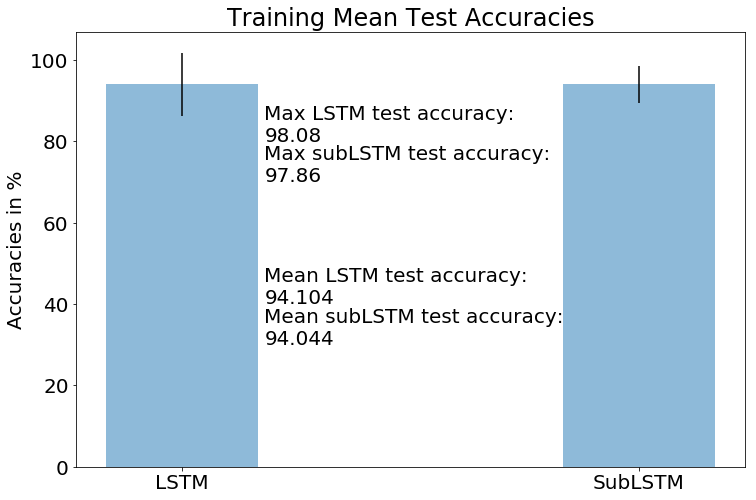

In [9]:
hp.bar_plot(objects, mean_accuracies, std_accuracies, accuracies)